In [1]:
import json
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import cv2

## Load Pandas Dataframe

In [2]:
albums_df = pd.read_pickle("./albums_df_large_img.pkl")

albums_df.head()

,artist_id,artist_name,album_id,album_name,album_popularity,genres,filepath,rap,rock,pop
0,5me0Irg2ANcsgc93uaYrpb,The Notorious B.I.G.,7dRdaGSxgcBdJnrOviQRuB,Life After Death (2014 Remastered Edition),78,[rap],.\images\7dRdaGSxgcBdJnrOviQRuB.jpg,1,0,0
1,36QJpDe2go2KgaRleHCDTp,Led Zeppelin,6P5QHz4XtxOmS5EuiGIPut,Led Zeppelin III (Remaster),74,[rock],.\images\6P5QHz4XtxOmS5EuiGIPut.jpg,0,1,0
2,5WUlDfRSoLAfcVSX1WnrxN,Sia,77jAfTh3KH9K2reMOmTgOh,This Is Acting,74,[pop],.\images\77jAfTh3KH9K2reMOmTgOh.jpg,0,0,1
5,246dkjvS1zLTtiykXe5h60,Post Malone,4g1ZRSobMefqF6nelkgibi,Hollywood's Bleeding,93,[rap],.\images\4g1ZRSobMefqF6nelkgibi.jpg,1,0,0
8,26dSoYclwsYLMAKD3tpOr4,Britney Spears,5PmgtkodFl2Om3hMXONDll,Oops!... I Did It Again,76,[rap],.\images\5PmgtkodFl2Om3hMXONDll.jpg,1,0,0


## Load images to dataframe

Load images and resize them to **320 x 320** pixels. 

Each image can be represented as a vector of 102.400 dimensions.

In [3]:
from skimage.io import imread
from skimage.transform import resize


image_list = []

for img_path in albums_df['filepath']:
    image = imread(img_path)
    resized_image = resize(image, (320,320)) 
    image_list.append(resized_image)
    
albums_df['img'] = image_list

## 1. Face Detection

The first feature to be extracted is the presence of face(s) in the album cover image. 
OpenCV's algorithm is currently using the following Haar-like features which are the input to the basic classifiers. 

**Parameters:**
- **image** : Matrix of the type CV_8U containing an image where objects are detected.

- **scaleFactor** : Parameter specifying how much the image size is reduced at each image scale. Suppose, the scale factor is 1.03, it means we're using a small step for resizing, i.e. reduce size by 3 %, we increase the chance of a matching size with the model for detection is found, while it's expensive. We're using 1.07 in the code. 

- **minNeighbors** : Parameter specifying how many neighbors each candidate rectangle should have to retain it. This parameter will affect the quality of the detected faces: higher value results in less detections but with higher quality. We're using 15 in the code.

Visualize the results for a random sample of images using OpenCV pre-trained face classifier.

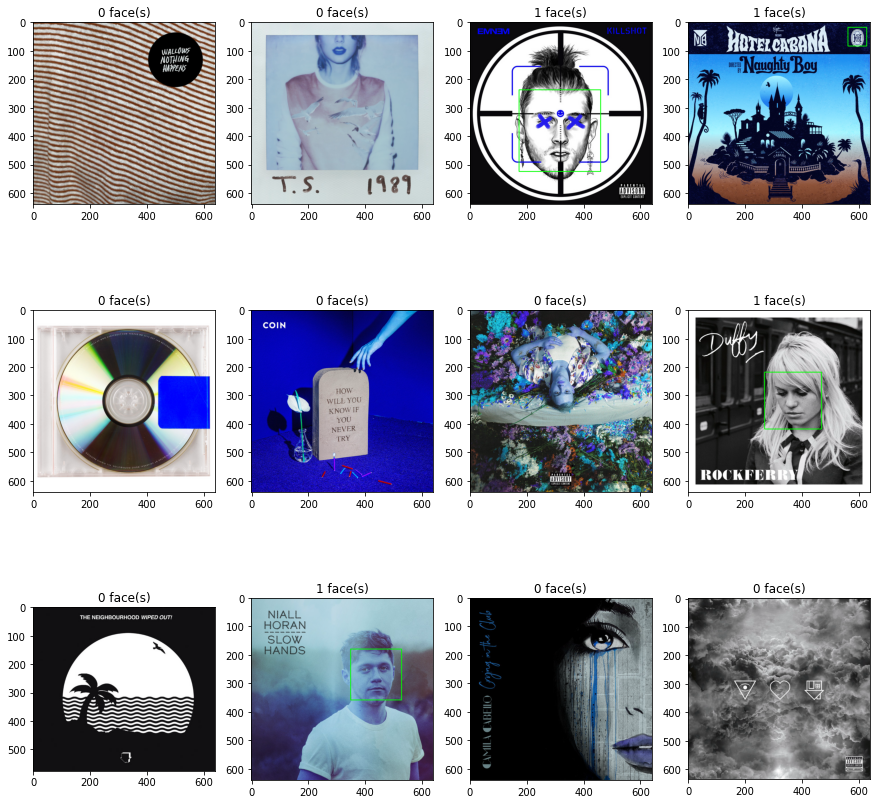

In [9]:
image_samples = albums_df.filepath.sample(n = 12) 

# OpenCV Face Classifier
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')    
scaleFactor = 1.07
minNeighbors = 15

fig=plt.figure(figsize=(15, 15))
columns = 4
rows = 3

for plot_number, filepath in enumerate(image_samples):
    image = cv2.imread(filepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(gray, scaleFactor, minNeighbors)
    
    for (x, y, w, h) in faces:
        cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)

    ax = fig.add_subplot(rows, columns, plot_number+1, )
    ax.title.set_text(f"{len(faces)} face(s)")
    plt.imshow(image)
    
plt.show()

Create the feature `has_face`

- **1** : if face(s) is present in the image
- **0** : otherwise

In [11]:
# OpenCV Face Classifier
faceCascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')    
scaleFactor = 1.07
minNeighbors = 15

has_face_list = []

for index, filepath in enumerate(albums_df.filepath):
    
    has_face = 0
    
    image = cv2.imread(filepath)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    faces = faceCascade.detectMultiScale(gray, scaleFactor, minNeighbors)
    
    if len(faces) > 0:
        has_face = 1
    has_face_list.append(has_face)
        
albums_df['has_face'] = has_face_list

Text(0.5, 0, 'has_face')

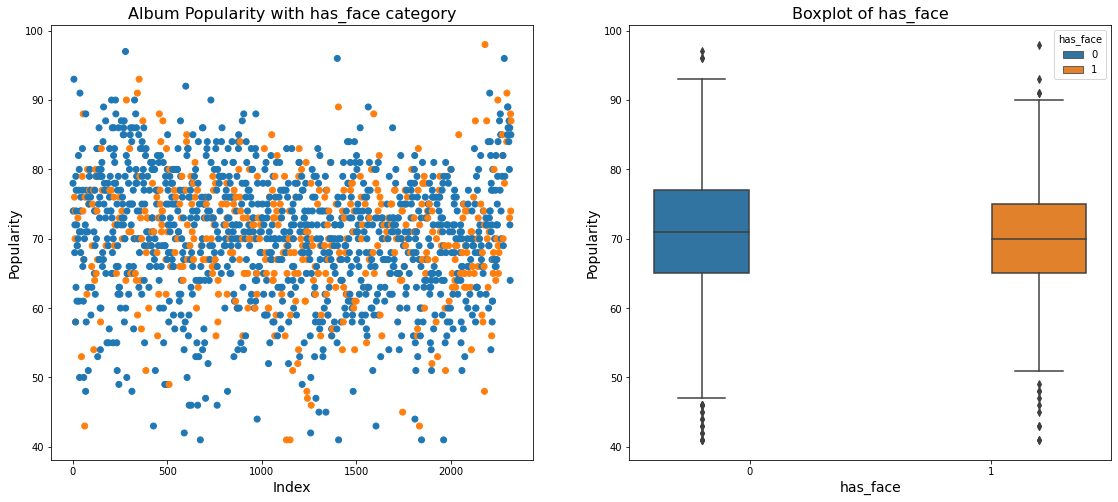

In [33]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(19,8))

x = albums_df.album_popularity
y = x.index
colors = {1:'#ff7f0e', 0:'#1f77b4'}

ax1.scatter(y, x, c = albums_df.has_face.map(colors))


ax1.set_ylabel("Popularity", size = 14)
ax1.set_xlabel("Index", size = 14)
ax1.set_title("Album Popularity with has_face category", size = 16)

ax2 = sns.boxplot(x='has_face' , y='album_popularity', 
                 data=albums_df, 
                 palette=colors,
                 hue='has_face')

ax2.set_title("Boxplot of has_face", size = 16)
ax2.set_ylabel("Popularity", size = 14)
ax2.set_xlabel("has_face", size = 14)

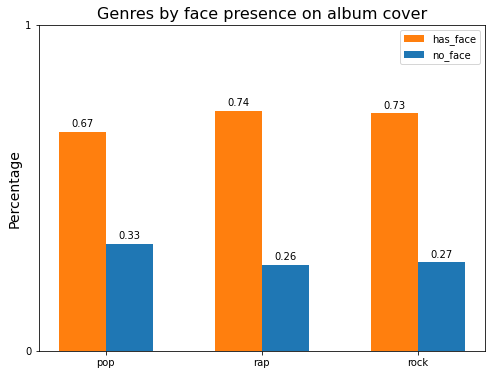

In [15]:
fig, (ax) = plt.subplots(1,1,figsize=(8,6))

labels = ['pop', 'rap', 'rock']
face = []
no_face = []

for item in labels:
    total = albums_df[item].value_counts()[1]
    face.append((total-albums_df[albums_df.has_face == 1][item].value_counts()[1])/total) 
    no_face.append((total-albums_df[albums_df.has_face == 0][item].value_counts()[1])/total) 

x = np.arange(len(labels))
width = 0.3 

rects1 = ax.bar(x - width/2, face, width, label='has_face', color = '#ff7f0e')
rects2 = ax.bar(x + width/2, no_face, width, label='no_face', color = '#1f77b4')


def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{:.2}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)

ax.set_ylabel('Percentage', size = 14)
ax.set_title('Genres by face presence on album cover', size = 16)
ax.set_xticks(x)
ax.set_yticks([0,1])
ax.set_xticklabels(labels)
ax.legend()

In [16]:
pd.to_pickle(albums_df, "./albums_df_s1.pkl")

In [17]:
albums_df = pd.read_pickle("./albums_df_s1.pkl")

## 2. HOG Descriptor

HOG, or Histogram of Oriented Gradients, is a feature descriptor that is often used to extract features from image data.

Some important aspects of HOG:

- HOG focuses on the **structure** of the object. It extracts the information of the **edges magnitude** and the **edges orientation**.
- These orientations are calculated in ‘localized’ portions. This means that the complete image is broken down into smaller regions and for each region, the gradients and orientation are calculated. 
- Finally the HOG would generate a **histogram** for each of these regions separately. The histograms are created using the gradients and orientations of the pixel values

*The HOG feature descriptor counts the occurrences of gradient orientation in localized portions of an image.*

We use the `skimage` implementation to compute the HOG descriptor.

**Parameters:**


- **image** : The target image you want to apply HOG feature extraction.
- **orientations** : Number of bins in the histogram created, we choose 9 as presented in the bibliography.
- **pixels_per_cell** : Determines the size of the cell.
- **cells_per_block** : Number of cells per block. 
- **visualize** : A boolean whether to return the image of the HOG.

A `cell` is a rectangular region defined by the number of pixels that belong in each cell. For example, if we had a 128 x 128 image and defined our pixels_per_cell  as 4 x 4, we would thus have 32 x 32 = 1024 cells.

To account for changes in illumination and contrast, we can normalize the gradient values locally. This requires grouping the `cells` together into larger, connecting `blocks`. It is common for these blocks to overlap, meaning that each cell contributes to the final feature vector more than once.

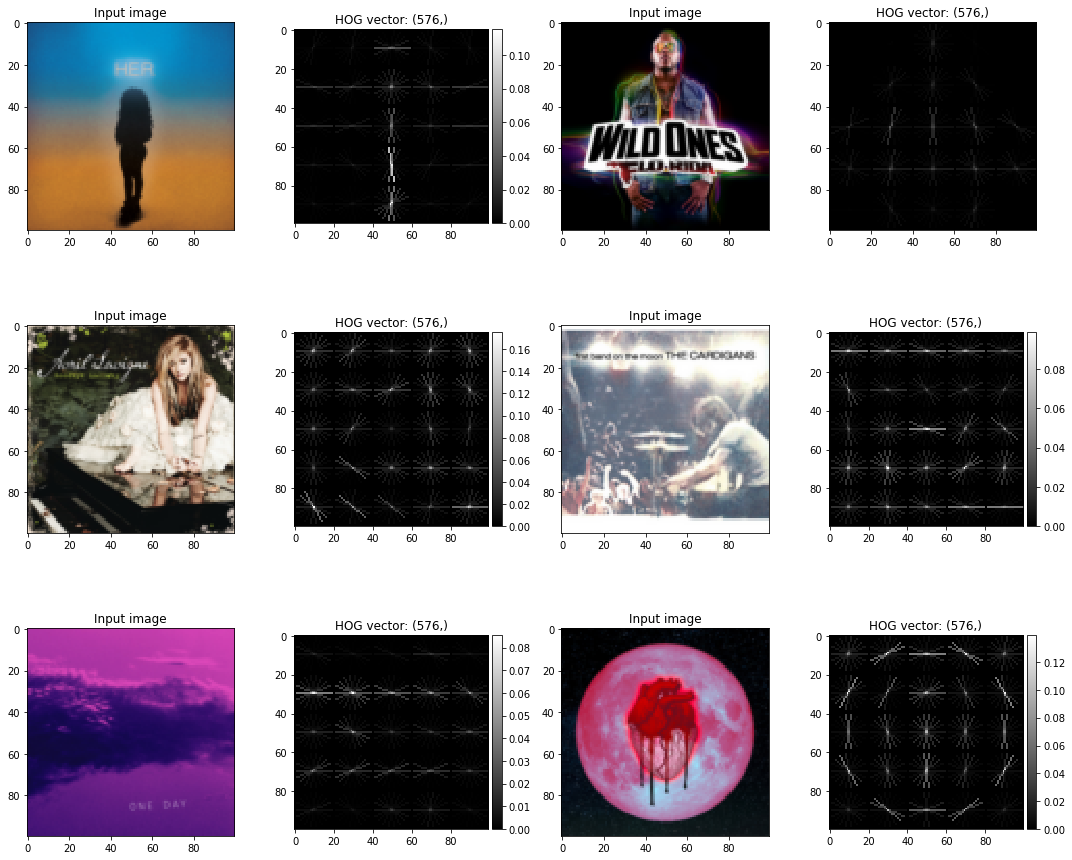

In [8]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure
from skimage.color import rgb2gray

image_samples = albums_df.filepath.sample(n = 6, random_state = 42) 
fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 3
hog_no = 0

for plot_number, filepath in enumerate(image_samples):
    image = imread(filepath)
    resized_img = resize(image, (100,100)) 
     
    
    fd, hog_image = hog(resized_img, orientations=9, pixels_per_cell=(20,20), 
                        cells_per_block=(2,2), visualize=True, multichannel=True,
                        transform_sqrt=True, block_norm="L1")
    
 
    ax1 = fig.add_subplot(rows, columns, plot_number+hog_no+1,)
    imshow(resized_img)
    ax1.set_title('Input image') 
    
    ax2 = fig.add_subplot(rows, columns, plot_number+hog_no+2,)
    imshow(hog_image, cmap=plt.cm.gray ) 
    ax2.set_title(f"HOG vector: {fd.shape}")
    
    hog_no+=1
    
plt.show()

Create the feature `hog_descriptor`

In [36]:
def fd_hog_descriptor(image):
    # skimage HOG descriptor
    orientations=9
    pixels_per_cell=(20,20)
    cells_per_block=(2,2)
    visualize=False
    multichannel=False
    transform_sqrt=True  
    block_norm="L2"
    
    resized_img = resize(image, (100,100)) 
    
    if resized_img.shape[-1] == 3:
        gray_img = rgb2gray(resized_img)
    else:
        gray_img=resized_img
        
        
    fd = hog(gray_img, 
             orientations=orientations, 
             pixels_per_cell=pixels_per_cell, 
             cells_per_block=cells_per_block, 
             visualize=visualize, 
             multichannel=multichannel,
             transform_sqrt=transform_sqrt,
             block_norm=block_norm)
    
    return fd

In [37]:
hog_descriptors = []

for index, filepath in enumerate(albums_df.filepath):  
    image = imread(filepath)
    hog_descriptors.append(fd_hog_descriptor(image))
      
albums_df['hog_descriptor'] = hog_descriptors

**Save features extracted so far**

In [38]:
pd.to_pickle(albums_df, "./albums_df_s1.pkl")

In [11]:
albums_df = pd.read_pickle("./albums_df_s1.pkl")

## 3. HSV Color Histogram - 3D

**HSV** (Hue, Saturation, Value) is an alternative representation of the RGB color model, designed to better align with the way human vision perceives color-making attributes. 

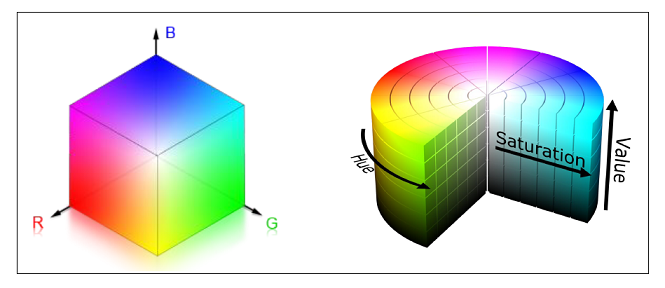

**It should be noted** that the histogram of an image does not keep track of the spatial information of the pixels in an image. Two images with the same number of color pixels but at different locations would have the same histogram. **This results in higher false-positives**.

OpenCV is used to convert image to HSV color space and extract the histogram.



**i. Convert to HSV**

To perform the color space conversion, we need to call the **cvtColor** function of the cv2 module. This function receives as first input the original image and as second input the color conversion code.

To choose the correct code, we need to take in consideration that, when calling the imread function, the image will be stored in **BGR** format. Thus, to convert to HSV, we should use the **COLOR_BGR2HSV** code.

**ii. Compute Histogram**

OpenCV provides the function **calcHist** to calculate the histogram of an image. 

**Parameters:**


- **image** : is the image we want to calculate the histogram of wrapped as a list
- **channels** : is the index of the channels to consider wrapped as a list  
- **mask** : is a mask to be applied on the image if we want to consider only a specific region
- **bins** : is a list containing the number of bins to use for each channel
- **ranges** : is the range of the possible pixel values which is (0,256)  in case of RGB color space (where 256 is not inclusive)



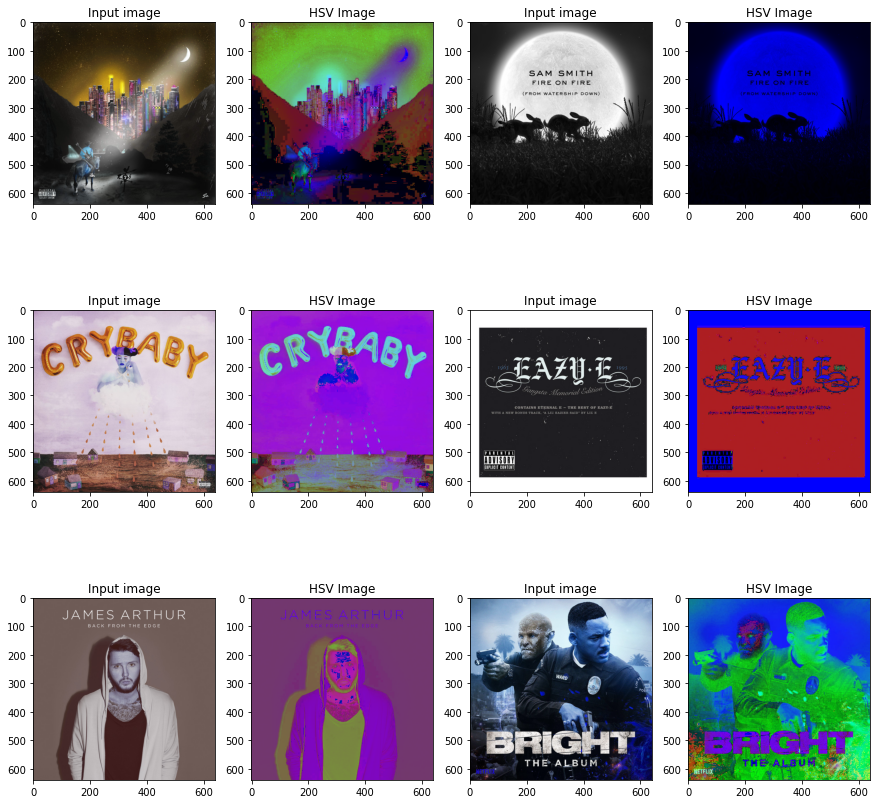

In [24]:
from skimage.io import imread, imshow

image_samples = albums_df.filepath.sample(n = 6) 
fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 3
im_no = 0

for plot_number, filepath in enumerate(image_samples):
    
    image = cv2.imread(filepath)
    hsvImage = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
 
    ax1 = fig.add_subplot(rows, columns, plot_number+im_no+1,)
    plt.imshow(image )

    ax1.set_title('Input image') 
    plt.hsv() 
    ax2 = fig.add_subplot(rows, columns, plot_number+im_no+2,)
    plt.imshow(hsvImage , cmap=plt.cm.hsv ) 
    ax2.set_title(f"HSV Image")
    
    im_no+=1

plt.show()

Create the feature `hsv_hist`

In [25]:
def fd_hsv_histogram(image):
    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    hsv_hist = cv2.calcHist([hsv_image], [0, 1, 2], None, [8, 8, 8], [0, 256, 0, 256, 0, 256])
    cv2.normalize(hsv_hist, hsv_hist)
    
    return hsv_hist.flatten()

In [26]:
hsv_histograms = []

for index, filepath in enumerate(albums_df.filepath):
    image = cv2.imread(filepath)
    hsv_histograms.append(fd_hsv_histogram(image))
      
albums_df['hsv_hist'] = hsv_histograms

In [27]:
pd.to_pickle(albums_df, "./albums_df_s1.pkl")

In [28]:
albums_df = pd.read_pickle("./albums_df_s1.pkl")

## 4. Local Binary Patterns - LBPs 

Local Binary Patterns image descriptor identifies **textures** and **patterns** in images. LBPs compute a local representation of texture. This local representation is constructed by comparing each pixel with its surrounding neighborhood of pixels.

Some important aspects of LBPs:
- A primary benefit of the original LBP implementation is that we can capture extremely fine-grained details in the image. 
- To capture details at varying scales, two parameters can be used 

    - The `number of points` p in a circularly symmetric neighborhood to consider
    - The `radius` of the circle r, which allows us to account for different scales


The following image contains three neighborhood examples with varying p and r used to construct Local Binary Patterns:

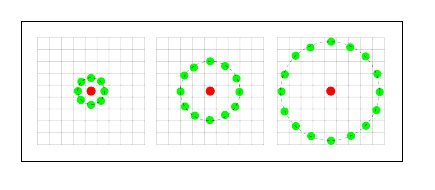

We use the `scikit-image` implementation of LBPs.

**Parameters:**

- **numPoints** : the number of points along the outer radius
- **radius** : the radius of the pattern surrounding the central pixel
- **method** : The `uniform` method indicates the rotation and grayscale invariant form of LBPs.

source: *https://www.pyimagesearch.com/2015/12/07/local-binary-patterns-with-python-opencv/*

In [29]:
def fd_local_binary_pattern(image):
    numPoints = 24
    radius = 8
    method="uniform"
    eps=1e-7
    
    if image.shape[-1] == 3:
        gray_img = rgb2gray(image)
    else:
        gray_img=image
        
    lbp = feature.local_binary_pattern(gray_img, numPoints, radius, method)

    (hist, _) = np.histogram(lbp.ravel(),
                             bins=np.arange(0, numPoints + 3), 
                             range=(0, numPoints + 2))

    # normalize the histogram
    hist = hist.astype("float")
    hist /= (hist.sum() + eps)
    
    return hist, lbp

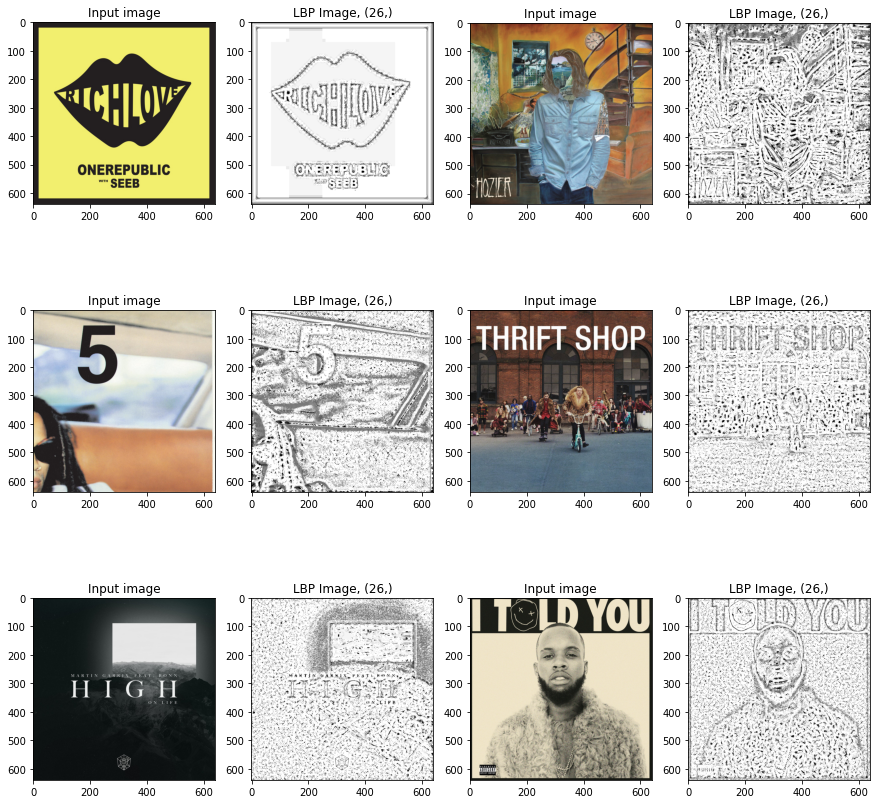

In [30]:
from skimage import feature
import numpy as np

 
image_samples = albums_df.filepath.sample(n = 6) 
fig = plt.figure(figsize=(15, 15))

columns = 4
rows = 3
im_no = 0

for plot_number, filepath in enumerate(image_samples):
    
    image = imread(filepath)
   
    hist, lbp = fd_local_binary_pattern(image)
    
    ax1 = fig.add_subplot(rows, columns, plot_number+im_no+1,)
    plt.imshow(image )
    ax1.set_title('Input image') 
    
    ax2 = fig.add_subplot(rows, columns, plot_number+im_no+2,)
    plt.imshow(lbp ,   cmap=plt.cm.gray ) 
    ax2.set_title(f"LBP Image, {hist.shape}")
    
    im_no+=1

plt.show()

Create the feature `lbp_hist`

In [31]:
lbp_histograms = []

for index, filepath in enumerate(albums_df.filepath):
    image = imread(filepath)
    hist, lbp = fd_local_binary_pattern(image)
    lbp_histograms.append(hist)
      
albums_df['lbp_hist'] = lbp_histograms

In [34]:
pd.to_pickle(albums_df, "./albums_df_s1.pkl")